In [1]:
import dynet as dy
import numpy as np

dyparams = dy.DynetParams()
dyparams.set_mem(2048)
dyparams.set_random_seed(1978)
dyparams.init()

# `dyNet` example: `spam` v. `ham`

## import features

In [2]:
import sys
sys.path.append("..")
import utils as u

In [3]:
# change this string to match the path on your computer
path_to_root = "/Users/mcapizzi/Github/dynet_tutorial/"

In [4]:
trainX, trainY, testX, testY = u.import_data(path_to_root)

loading training data
loading test data


In [5]:
trainX.shape, trainY.shape

((953, 2955), (953,))

In [6]:
testX.shape, testY.shape

((105, 2955), (105,))

In [7]:
testY

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1])

In [8]:
np.nonzero(testX[20])

(array([   0,   21,   27,   47,   77,   93,  118,  147,  229,  231,  239,
         245,  247,  251,  274,  308,  333,  362,  388,  432,  461,  467,
         501,  502,  504,  534,  541,  596,  612,  613,  616,  619,  622,
         627,  636,  657,  741,  763,  816,  845,  849,  870,  885,  921,
         972,  991, 1024, 1060, 1083, 1116, 1128, 1160, 1224, 1258, 1290,
        1322, 1327, 1393, 1408, 1419, 1424, 1437, 1456, 1530, 1531, 1566,
        1625, 1628, 1636, 1643, 1685, 1740, 1751, 1803, 1867, 1936, 1956,
        2004, 2007, 2032, 2053, 2091, 2120, 2121, 2135, 2146, 2163, 2202,
        2205, 2210, 2335, 2374, 2376, 2392, 2427, 2453, 2460, 2466, 2478,
        2487, 2516, 2526, 2544, 2547, 2557, 2575, 2578, 2599, 2627, 2670,
        2678, 2679, 2690, 2701, 2730, 2765, 2790, 2812, 2830, 2856, 2883,
        2887, 2889, 2899]),)

In [9]:
trainX[20][47]

0.01383399209486166

## build architecture
all images borrowed from here: http://u.cs.biu.ac.il/~yogo/nnlp.pdf (now a book!)

![goldberg_nn](images/goldberg_ff.png)

![goldberg_ff_math](images/goldberg_ff_math.png)

### initialize empty model

See http://dynet.readthedocs.io/en/latest/python_ref.html#parametercollection

In [10]:
feed_forward_model = dy.ParameterCollection()   # used to be called dy.Model()
feed_forward_model

### dimensions

In [11]:
# size of input (2955)
input_size = trainX.shape[1]
# size of hidden layer
hidden_size = 200

### weight matrices and bias vectors
![goldberg_math_simple](images/goldberg_ff_math_simple.png)

#### paramater `initializer`
See http://dynet.readthedocs.io/en/latest/python_ref.html#parameters-initializers

In [12]:
initializer = dy.GlorotInitializer(gain=4.0)

In [13]:
# W_1 (input x hidden) as a Parameters object
pW_1 = feed_forward_model.add_parameters(
    (input_size, hidden_size),
    init=initializer
)
type(pW_1), type(dy.parameter(pW_1))

(_dynet.Parameters, _dynet.Expression)

In [14]:
# check the shape of the Expression
dy.parameter(pW_1).npvalue().shape

(2955, 200)

In [15]:
# b_1 (1 x hidden) as a Parameters object
pb_1 = feed_forward_model.add_parameters(
    (1, hidden_size),
    init=initializer
)
# check the shape
dy.parameter(pb_1).npvalue().shape

(1, 200)

In [16]:
# W_2 (hidden x output) as a Parameters object
pW_2 = feed_forward_model.add_parameters(
    (hidden_size, 1),
    init=initializer
)
# check the shape
dy.parameter(pW_2).npvalue().shape

(200, 1)

In [17]:
# b_2 (1 x output) as a Paramters object
pb_2 = feed_forward_model.add_parameters(
    (1, 1),
    init=initializer
)
# check the shape
dy.parameter(pb_2).npvalue().shape

(1, 1)

### forward operations
![goldberg_math_simple](images/goldberg_ff_math_simple.png)

In [18]:
def forward_pass(x):
    """
    This function will wrap all the steps of the forward pass
    :param x: the input
    """
    # convert input to Expression (this step must happen here b/c of autobatching)
    x = dy.inputTensor(x)
    # convert Parameters to Expressions
    W_1 = dy.parameter(pW_1)
    b_1 = dy.parameter(pb_1)
    W_2 = dy.parameter(pW_2)
    b_2 = dy.parameter(pb_2)
    # calculate the first hidden layer
    hidden = x * W_1 + b_1          
    # calculate the sigmoid activation
    hidden_activation = dy.logistic(hidden)    
    # calculate the output layer
    output = hidden_activation * W_2 + b_2
    # return the sigmoid of the output
    return dy.logistic(output)

### training

#### initializing a `trainer`
See http://dynet.readthedocs.io/en/latest/python_ref.html#optimizers

In [19]:
trainer = dy.SimpleSGDTrainer(
    m=feed_forward_model,
    learning_rate=0.01
)

### autobatching
See http://dynet.readthedocs.io/en/latest/minibatch.html#

In [21]:
dyparams = dy.DynetParams()
dyparams.set_autobatch(True)
dyparams.set_mem(2048)
dyparams.set_random_seed(1978)
dyparams.init()

#### one `epoch`

In [22]:
# store original values of W_1
original_W1 = dy.parameter(pW_1).npvalue()
# begin a clean computational graph
dy.renew_cg()
# initialize list to capture individual losses
losses = []

In [23]:
# iterate through the dataset
for i in range(trainX.shape[0]):
    # prepare input
    x = np.expand_dims(trainX[i], axis=0)   # must make it a vector with dimensions (1 x voc_size)
    # prepare output
    y = dy.scalarInput(trainY[i])
    # make a forward pass
    pred = forward_pass(x)
    # calculate loss for each example
    loss = dy.binary_log_loss(pred, y) 
    losses.append(loss)

In [24]:
# get total loss for dataset
total_loss = dy.esum(losses)
# apply the calculations of the computational graph
total_loss.forward()
# calculate loss to backpropogate
total_loss.backward()
# update parameters with backpropogated error
trainer.update()

In [25]:
# confirm that parameters updated
dy.renew_cg()
print("change in W_1 parameter values: {}".format(
    np.sum(original_W1 - dy.parameter(pW_1).npvalue())
))

change in W_1 parameter values: 0.004230523849315659


### testing

#### make a single prediction

In [26]:
pred = forward_pass(np.expand_dims(testX[0], axis=0))
print(pred.value())

0.032890334725379944


#### get predictions on entire test set

In [27]:
all_preds = []
dy.renew_cg()
for i in range(testX.shape[0]):
    x = np.expand_dims(testX[i], axis=0)
    pred = forward_pass(x)
    all_preds.append(pred.value())
original_preds = all_preds

In [28]:
print(original_preds)

[0.032890334725379944, 0.03312969580292702, 0.03335326910018921, 0.03289978578686714, 0.03276115655899048, 0.032902076840400696, 0.03261207044124603, 0.03242418169975281, 0.0325341671705246, 0.033869944512844086, 0.03316130489110947, 0.033259496092796326, 0.0339745469391346, 0.03289671987295151, 0.03277042508125305, 0.03276296705007553, 0.03249910846352577, 0.03389919549226761, 0.0329652838408947, 0.03329315036535263, 0.033141106367111206, 0.03266499564051628, 0.03226098045706749, 0.03320048749446869, 0.033435024321079254, 0.03258293494582176, 0.03279656171798706, 0.032985758036375046, 0.03221329301595688, 0.03259793296456337, 0.03358956798911095, 0.034096453338861465, 0.03343535587191582, 0.03276187926530838, 0.033528883010149, 0.032876595854759216, 0.03345732018351555, 0.03317318484187126, 0.033049073070287704, 0.032904092222452164, 0.033035796135663986, 0.031977664679288864, 0.033022914081811905, 0.03365425020456314, 0.032270196825265884, 0.03327720984816551, 0.03315359354019165, 0.

In [29]:
def check_score(pred, true_y):
    # convert pred to hard label
    label = 1 if pred >= 0.5 else 0
    # compare to true_y
    return 1 if label == true_y else 0

In [30]:
def get_accuracy(list_of_scores):
    return float(sum(list_of_scores) / len(list_of_scores))

In [31]:
accuracy = get_accuracy([check_score(p, y) for p,y in zip(all_preds, list(testY))])
accuracy

0.4666666666666667

### multiple epochs and minibatches

In [32]:
num_epochs = 1000
batch_size = 128
num_batches = int(np.ceil(trainX.shape[0] / batch_size))
num_batches

8

In [33]:
# bookeeping
original_W1 = dy.parameter(pW_1).npvalue()
epoch_losses = []
all_accuracies = []

In [34]:
# iterate through epochs
for i in range(num_epochs):
    epoch_loss = []
    if i % 100 == 0:
        print("epoch {}".format(i+1))
    # shuffle dataset
    np.random.seed(i)
    np.random.shuffle(trainX)
    np.random.seed(i)           # make sure to reset seed again to keep labels and data together!
    np.random.shuffle(trainY)
    # iterate through batches
    for j in range(num_batches):
        # begin a clean computational graph *at beginning of each batch*
        dy.renew_cg()
        losses = []
        # build the batch
        batchX = trainX[j*batch_size:(j+1)*batch_size]
        batchY = trainY[j*batch_size:(j+1)*batch_size]
        # iterate through the batch
        for k in range(batchX.shape[0]):
            # prepare input
            x = np.expand_dims(batchX[k], axis=0)
            # prepare output
            y = dy.scalarInput(batchY[k])
            # make a forward pass
            pred = forward_pass(x)
            # calculate loss for each example
            loss = dy.binary_log_loss(pred, y)  
            losses.append(loss)
        # get total loss for batch
        total_loss = dy.esum(losses)
        # applies the calculations of the computational graph
        total_loss.forward()
        # calculates loss to backpropogate
        total_loss.backward()
        # update parameters with backpropogated error
        trainer.update()
        # record batch loss
        epoch_loss.append(total_loss.npvalue())
    # record epoch loss
    epoch_losses.append(np.sum(epoch_loss))
    # check performance on test set
    all_preds = []
    dy.renew_cg()
    for i in range(testX.shape[0]):
        x = np.expand_dims(testX[i], axis=0)
        pred = forward_pass(x)
        all_preds.append(pred.value())
    accuracy = get_accuracy([check_score(p, y) for p,y in zip(all_preds, list(testY))])
    all_accuracies.append(accuracy)
# confirm that parameters updated
dy.renew_cg()
print("change in W_1 parameter values: {}".format(
    np.sum(original_W1 - dy.parameter(pW_1).npvalue())
))

epoch 1
epoch 101
epoch 201
epoch 301
epoch 401
epoch 501
epoch 601
epoch 701
epoch 801
epoch 901
change in W_1 parameter values: 0.3589535474160357


### visualize loss and accuracy

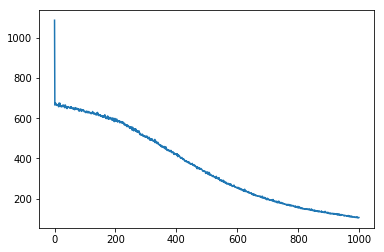

In [35]:
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.show()

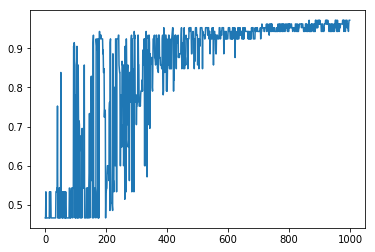

In [36]:
plt.plot(all_accuracies)
plt.show()

### testing

In [37]:
all_preds = []
dy.renew_cg()
for i in range(testX.shape[0]):
    x = np.expand_dims(testX[i], axis=0)
    pred = forward_pass(x)
    all_preds.append(pred.value())

In [38]:
accuracy = get_accuracy([check_score(p, y) for p,y in zip(all_preds, list(testY))])
accuracy

0.9714285714285714

In [40]:
print(all_preds)

[0.9928320646286011, 0.03397256135940552, 0.023673199117183685, 0.9413061141967773, 0.10912294685840607, 0.09180933237075806, 0.15185657143592834, 0.9829750061035156, 0.9984959959983826, 0.9795349836349487, 0.8904619812965393, 0.9704824090003967, 0.9803579449653625, 0.991703450679779, 0.09739886224269867, 0.0625636875629425, 0.9968883395195007, 0.6011726260185242, 0.02273273654282093, 0.1664777398109436, 0.019492700695991516, 0.13371717929840088, 0.0828305184841156, 0.9210159778594971, 0.6415531039237976, 0.9714575409889221, 0.037872109562158585, 0.06353715807199478, 0.05367226526141167, 0.9382825493812561, 0.043739378452301025, 0.00014514762733597308, 0.04499735310673714, 0.025725338608026505, 0.055009376257658005, 0.9738768339157104, 0.6865576505661011, 0.11978664249181747, 0.40830719470977783, 0.9735152721405029, 0.019166238605976105, 0.904233455657959, 0.03331451117992401, 0.9807868003845215, 0.3391875624656677, 0.8210709691047668, 0.02023393101990223, 0.05242954194545746, 0.898612